In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal

In [2]:
def make_hann_2D(n):
    w = scipy.signal.hann(n)
    wx,wy = np.meshgrid(w,w)
    w2 = wx*wy
    return w2, np.sqrt(np.mean(w2**2))

def img2PS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=False,usehann=True):

    N = img.shape[0]
    hann2D,hann2Drms = make_hann_2D(N)
    lvals = np.fft.fftfreq(N)*2*np.pi/dtheta_rad
    lx,ly = np.meshgrid(lvals,lvals)
    lmag  = np.sqrt(lx**2+ly**2)
    print(np.max(lmag))

    img_ft = np.fft.fft2((img-img.mean())*hann2D)/hann2Drms
    
    if uselogbins: 
        lbinedges = 10.**np.linspace(np.log10(lmin),np.log10(lmax),nbins+1)
    else:
        lbinedges = np.linspace(lmin,lmax,nbins+1)
    lbincenters = .5*(lbinedges[0:nbins]+lbinedges[1:nbins+1])
    
    pspec_binned = np.zeros(nbins)

    bin_counts = np.zeros(nbins)
    for bini in range(nbins):
        inbin = (lmag>lbinedges[bini])&(lmag<lbinedges[bini+1])
        bin_counts[bini] = np.sum(inbin)

        pspec_binned[bini] = np.mean(np.abs(img_ft[inbin])**2)

    pspec_norm = (dtheta_rad**2)/(N**2)
    return lbincenters,pspec_binned*pspec_norm,bin_counts

def img2optimalPS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=True):
    n = img.shape[0]
    lvals = fft.fftfreq(n)*2*pi/dtheta_rad
    lxgrid,lygrid = meshgrid(lvals,lvals)
    lmaggrid = sqrt(lxgrid**2+lygrid**2)
    
    thvals = (arange(n)-n/2)*dtheta_rad # theta values
    thxgrid,thygrid = meshgrid(thvals,thvals)
    
    img = (img-img.mean())
    xir = transpose(matrix(img.flatten()))

    if uselogbins: 
        lbinedges = 10.**np.linspace(np.log10(lmin),np.log10(lmax),nbins+1)
    else:
        lbinedges = np.linspace(lmin,lmax,nbins+1)
    lbincenters = .5*(lbinedges[0:nbins]+lbinedges[1:nbins+1])
    
    Pir = zeros(nbins)
    Fisher = zeros(nbins) # could try later making this a matrix to do matrix normalization, but for now just leave it
    
    for bini in range(nbins):
        print 'bin='+str(bini)
        inbin = (lmaggrid>=lbinedges[bini])*(lmaggrid<lbinedges[bini+1])
        ivals_inbin,jvals_inbin = where(inbin)

        print 'initializing Ccomma matrix'
        lxvals,thxvals = meshgrid(lxgrid[ivals_inbin,jvals_inbin],thxgrid.flatten()) # ell_x and theta_x
        lyvals,thyvals = meshgrid(lygrid[ivals_inbin,jvals_inbin],thygrid.flatten()) # ell_y and theta_y
        Ccommabini_lu = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))
        Ccommabini = Ccommabini_lu*conj(transpose(Ccommabini_lu))

        print 'computing Fisher'
        Fisher[bini] = real(.5*trace(Ccommabini*Ccommabini))

        print 'evaluating quadratic estimater'
        Pir[bini] = .5*real(transpose(xir)*Ccommabini*xir).item()/Fisher[bini]*n**4 # .item() gets the single element in this matrix

    return lbincenters,Pir*(dtheta_rad**2)/(n**2)

In [3]:
# generate an image from a non-flat power spectrum
n = 50
dtheta_amin = 3.
dtheta_rad = dtheta_amin/60*np.pi/180

lvals = fft.fftfreq(n)*2*pi/dtheta_rad
lxgrid,lygrid = meshgrid(lvals,lvals)
lmaggrid = sqrt(lxgrid**2+lygrid**2)

img_ft = (np.random.randn(n,n)+1j*np.random.randn(n,n))/sqrt(2)/(lmaggrid+1)
img = np.real(np.fft.ifft2(img_ft)) # taking the real part enforces conjugate symmetry in fourier space

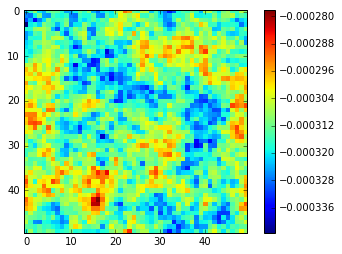

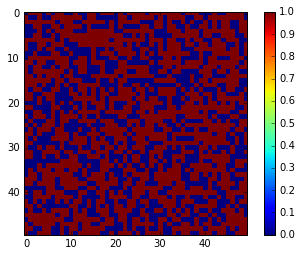

In [4]:
plt.imshow(img,interpolation='nearest')
plt.colorbar()

plt.figure()
mask = np.random.randn(n,n)>-.2
plt.imshow(mask,interpolation='nearest')
plt.colorbar()

In [ ]:
lbins,pspec,bin_counts = img2PS(img,dtheta_rad,10,1,5000,uselogbins=True)
lbins,pspec_m,bin_counts = img2PS(img*mask,dtheta_rad,10,1,5000,uselogbins=True)

lbins,pspec_o = img2optimalPS(img,dtheta_rad,5,1,5000,uselogbins=True)
lbins,pspec_m_o = img2optimalPS(img*mask,dtheta_rad,5,1,5000,uselogbins=True)

5091.16882454
5091.16882454
bin=0
initializing Ccomma matrix
computing Fisher
evaluating quadratic estimater
bin=1
initializing Ccomma matrix
computing Fisher


/Users/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:72: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
plt.loglog(lbins,pspec,'b.-')
plt.loglog(lbins,pspec_m,'r.-')

plt.loglog(lbins,pspec_o,'b:')
plt.loglog(lbins,pspec_m_o,'r:')